In [1]:
import gurobi as gb
from gurobipy import GRB

import networkx as nx
import numpy as np
import math

In [2]:
from functions_library import *

In [3]:
opt_mod = gb.Model(name="linear programm")
#opt_mod.setParam("IterationLimit",400000)
#opt_mod.setParam("DegenMoves",0);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-02


In [4]:
k = 4
G = init_ring(2**k)
D = init_uniformDemand_matrix_symmetric(G)
nodesPairListNoDuplication = complete_node_pair_list_noDuplication(G)
n = len(G.nodes)

In [5]:
e = opt_mod.addMVar((n,n), name="e", vtype="I",lb=0,ub=1)
SP = opt_mod.addMVar((n,n,n), name="sp", vtype="C", lb=0, ub=GRB.INFINITY)
helper = opt_mod.addMVar((n,n), name="sp", vtype="C", lb=0, ub=GRB.INFINITY)
opt_mod.update()

In [15]:
# Adjacency Matrix (e) Constraints
opt_mod.addConstrs((e[i,(i+1) % n] == 1 for i in G.nodes), name="c-ring")
opt_mod.addConstrs((e[i,i] == 0 for i in G.nodes), name="c-noSelfEdge")
opt_mod.addConstrs((e[i,j] == e[j,i] for i in G.nodes for j in G.nodes), name="c-undirected")

maxNumberE =  k+1 #math.log(n,2)-1 + 2
opt_mod.addConstrs((e[i,:].sum() <= maxNumberE for i in G.nodes), name="c-logE")
opt_mod.update() 


opt_mod.addConstrs((SP[0,i,j] == ((1-e[i][j])*n)+(e[i][j]) for i in G.nodes for j in G.nodes))
 
# Ensuring that x shows a correct path
for k in range(1,n):
    for i in G.nodes:
        for j in G.nodes:
            if i!=j:
                opt_mod.addConstr(SP[k,i,j] <= SP[k-1,i,j])
                opt_mod.addConstr(SP[k,i,j] <= SP[k-1,i,k] + SP[k-1,k,j])
                #opt_mod.addConstr((SP[k-1,i,j] >= SP[k-1,i,k] + SP[k-1,k,j]) >> (SP[k,i,j]==SP[k-1,i,k] + SP[k-1,k,j]))

In [9]:
#print(len(x[0,1,x,y]))
opt_mod.setObjective(sum([SP[i,j,n-1]*D[i][j] for (i,j) in nodesPairListNoDuplication]), GRB.MINIMIZE)
opt_mod.update()


# Run
#opt_mod.display()
opt_mod.optimize()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 8320 rows, 4608 columns and 20560 nonzeros
Model fingerprint: 0xf636bdda
Variable types: 4352 continuous, 256 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [7e-02, 7e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]

MIP start from previous solve did not produce a new incumbent solution
MIP start from previous solve violates constraint c-logE[1] by 1.000000000

Presolve removed 8320 rows and 4608 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.01 work units)
Thread count was 1 (of 12 available processors)

Solution count 1: 15 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.500000075000e+01, best bound 1.500000075000e+01, gap 0.0000%


68.2666700799998


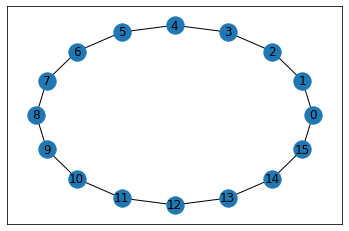

In [10]:
G_sol = nx.Graph()
for i in range(len(G.nodes)): 
    G_sol.add_node(i)

for i in G_sol.nodes:
    for j in range(i+1,len(G_sol.nodes)):
        if e[i,j].X == 1.0:
            G_sol.add_edge(i,j)
pos = nx.circular_layout(G_sol)
nx.draw_networkx(G_sol,pos=pos,with_labels=True)
print(calc_cost(G_sol,D))

In [ ]:
print(G_sol.edges)